# Wavernn

### Neural Synthesizer has been proven to be way powerful than statistical synthesize, but there has been core issue of performance, this implementaion is based on a paper which helps in reducing that performance requirement

In [1]:
%matplotlib inline
#matplotlib inline provides support to render plots directly in the jupyter notebook, it gets handy

In [2]:
"""
This model has been completely developed upon tensorflow, it uses numpy and math to calculate different mathematical functions.
My initial testing includes mathematical functions due to computation overhead of sound files.

function of clear_output is to clear the consoles, comes handy
"""
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import math
from tqdm import tqdm

#### Hyper params have been defined in the central location for easy access

In [3]:
hyper_parameters={
    "length_of_wave":100000, # Total length of sine wave // trained on sine wave to better analyse whole algorithm
    "sample_rate":16000, # number of samples in a second
    "batch_size":1, # number of batches
    "max_sequence_length":100, # maximum number of sequential steps, this network can generate (should be 1k but it is computationally costly and requires much more training time)
    "number_input_in_each_instant":{
        "coarse":2, # to incorporate [c(t-1),f(t-1)]
        "fine":3 # to incorporate [c(t-1),f(t-1),c(t)]
    },
    "number_of_the_rnn_cells":896, #Defined in the paper
    "depth_of_relu_networks":896, #Defined in the paper
    "softmax_probability":256, #By using 256, we can level the output in terms of probability, thus better ways to analyse
    "number_of_layers_in_rnns":2, #Needs to find best layer size
    "new_sequences": 10, # while generating how many new sequence it should generate
}

#### This block is used to generate the input samples

In [4]:
# Next line is used to generate sine wave
function = np.sin(np.arange(hyper_parameters['length_of_wave']) * 2 * np.pi /hyper_parameters['sample_rate']).astype(np.float32)

# Clipping Extra output, so that it can range between [0, 2^16] for label classication
function=np.clip(function * math.pow(2,15), -math.pow(2,15), math.pow(2,15) - 1).astype(np.int16)+2**15

# Calculating coarse and fine parts of the wave
coarse_part=function//256
fine_part=function%256

# Input and Output vector of both types respectively
X={
    "coarse":list(),
    "fine":list()
}
y={
    "coarse":list(),
    "fine":list()
}

# Converting sine wave data into feature sets as described in the paper
for e in range(1,hyper_parameters['length_of_wave']-1):
    # X has been divided by 256 to normalize the input data
    # while y hasnt been because we will be making y as one hot encoding vector.
    X['coarse'].append([coarse_part[e-1]/256.0,coarse_part[e-1]/256.0])
    X['fine'].append([coarse_part[e-1]/256.0,fine_part[e-1]/256.0,coarse_part[e]/256.0])
    y['coarse'].append([coarse_part[e]])
    y['fine'].append([fine_part[e]])

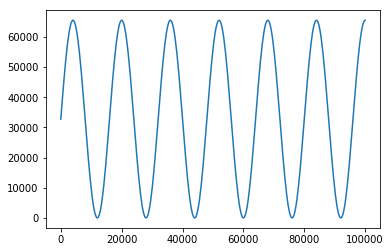

In [5]:
# plot of the input function for illustrative purposes
plt.plot(function)

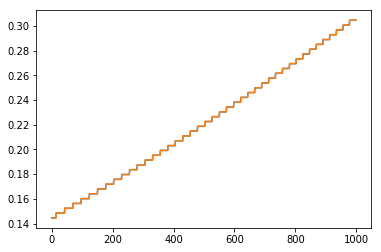

In [6]:
# In the same way, coarse has been plotted to better understand the data
plt.plot(X['coarse'][30000:31000])
plt.show()

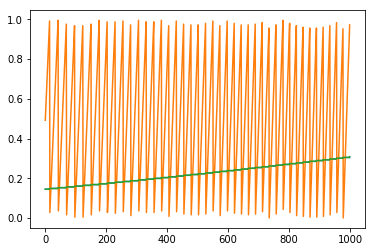

In [7]:
# In the same way, fine has been plotted to better understand the data
# green lines belong to c(t), while orange to f(t)
plt.plot(X['fine'][30000:31000])
plt.show()

### This block contains some manipulation over tensors to ease the architecture defined in the next block

In [8]:
def get_output_from_deep(type_of_input):
    # In the next line, we calculate index of an element whose value is maximum
    probablistic_best_level=tf.nn.top_k(tf.nn.softmax(deep_layer[type_of_input]),1)[1]
    # Used to normalize the output from the neural netwoks
    return tf.divide(probablistic_best_level,tf.constant(256))

def get_deep_layer(type_of_input):
    # Next line is used to change the shape of the output function, both of these lines denotes a fully connected neural network
    hidden_output=tf.nn.relu(tf.matmul(last_time_instant[type_of_input], weights['deep_layer'][type_of_input]) + bias['deep_layer'][type_of_input])
    return tf.matmul(hidden_output, weights['output_layer'][type_of_input]) + bias['output_layer'][type_of_input]


### Architecture of the Wavernn

In [ ]:
input_types=["coarse","fine"]

tf_input={
    "X":{},
    "y":{}
}


number_of_the_rnn_cells=896
depth_of_relu_networks=896
softmax_probability=256
number_of_layers_in_rnns=2


# 4 different types of weights and biased have been used to make the connection more viable and to transfer shape from `X1->X2`
weights={
    "deep_layer":{
       "coarse":tf.Variable(tf.random_normal(shape=[number_of_the_rnn_cells,depth_of_relu_networks]),dtype=tf.float32),
       "fine":tf.Variable(tf.random_normal(shape=[number_of_the_rnn_cells,depth_of_relu_networks]),dtype=tf.float32)
    },
    "output_layer":{
        "coarse":tf.Variable(tf.random_normal(shape=[depth_of_relu_networks,softmax_probability]),dtype=tf.float32),
        "fine":tf.Variable(tf.random_normal(shape=[depth_of_relu_networks,softmax_probability]),dtype=tf.float32)
    }
}
bias={
    "deep_layer":{
       "coarse":tf.Variable(tf.random_normal(shape=[depth_of_relu_networks]),dtype=tf.float32),
       "fine":tf.Variable(tf.random_normal(shape=[depth_of_relu_networks]),dtype=tf.float32)
    },
    "output_layer":{
        "coarse":tf.Variable(tf.random_normal(shape=[softmax_probability]),dtype=tf.float32),
        "fine":tf.Variable(tf.random_normal(shape=[softmax_probability]),dtype=tf.float32)
    }
}

# All of the next code lines is to reprepresent whole architecture in terms of the tensors

#gru cell, gru is just like RNN cell (more powerfull) though this parameters contains layer of the input.
gru_cells={}
# densed_Cell is used to make layers of rnn_cell, juse like a single one
densed_gru_cells={}
# raw_time_outputs gives raw outputs from gru tensors.
raw_time_outputs={}
# In last_time_instant, transposed is perform so that output only contains last iteration
last_time_instant={}
# deep_layer is intialized when we perform an relu operation over linear transformation.
deep_layer={}
# output layer takes output directly from relu and does another linear transformation.
output_layer={}
# to store costs of of the different batch entries
different_costs={}
# Adam optimizer, need to tune its hyperpara
optimizer={}

# this loop performs manager each of the tensors
for type_of_input in input_types:
    # In the next two lines, we are initializing X and y
    tf_input['X'][type_of_input]=tf.placeholder(tf.float32,[hyper_parameters['batch_size'],hyper_parameters['max_sequence_length'],hyper_parameters['number_input_in_each_instant'][type_of_input]])
    tf_input['y'][type_of_input]=tf.placeholder(tf.float32,[hyper_parameters['batch_size'],hyper_parameters['softmax_probability']])
    # Building block of gru
    gru_cells[type_of_input]=[tf.contrib.rnn.GRUCell(number_of_the_rnn_cells,name=type_of_input+"_gru") for x in range(number_of_layers_in_rnns)]
    # Densed rnn cell using MultiRNNCell
    densed_gru_cells[type_of_input]=tf.contrib.rnn.MultiRNNCell(gru_cells[type_of_input])
    # Next funcion will help you to synthesize 
    raw_time_outputs[type_of_input]=tf.nn.dynamic_rnn(densed_gru_cells[type_of_input],tf_input['X'][type_of_input],dtype=tf.float32)[0]
    # This function will reduce any output except for those which we have discussed
    last_time_instant[type_of_input]=tf.transpose(raw_time_outputs[type_of_input],[1,0,2])[-1]
    # function for deal_learning
    deep_layer[type_of_input]=get_deep_layer(type_of_input)
    # functoin for output synthesizing
    output_layer[type_of_input]=get_output_from_deep(type_of_input)
    different_costs[type_of_input]=tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_input['y'][type_of_input],logits=deep_layer[type_of_input])
total_cost=sum([different_costs[type_of_input] for type_of_input in input_types])
# total_cost=different_costs['coarse']+different_costs['']
optimizer=tf.train.AdamOptimizer().minimize(total_cost)


In [ ]:
# defining interactive session for ease of usage
tf.InteractiveSession()

In [ ]:
# Initializing global variables
tf.global_variables_initializer().run()

## Training Block

In [ ]:
# This array maintains cost function.
cost_output=[]
# for how many a steps, rnn whould run
number_of_steps=15
for e in tqdm(range(number_of_steps)):
    # starting_index ise used to randomly select starting point for better generalization
    starting_index=np.random.randint(hyper_parameters['length_of_wave']-hyper_parameters['max_sequence_length']-2)
    
    # Intialization
    X_coarse=[]
    y_coarse=[]
    X_fine=[]
    y_fine=[]
    
    #One hot encoding for y
    encoding_array=np.zeros(hyper_parameters['softmax_probability'])
    encoding_array[y['coarse'][starting_index+hyper_parameters['max_sequence_length']-1]]=1
    
    # Appended coarse based output on X
    X_coarse.append(np.asarray(X['coarse'][starting_index:starting_index+hyper_parameters['max_sequence_length']]).reshape(hyper_parameters['max_sequence_length'],2))
    
    # Appended y as one hot encoding
    y_coarse.append(encoding_array)
    encoding_array=np.zeros(hyper_parameters['softmax_probability'])
    encoding_array[y['fine'][starting_index+hyper_parameters['max_sequence_length']-1]]=1
    
    # Same intialization as with X_coarse
    X_fine.append(np.asarray(X['fine'][starting_index:starting_index+hyper_parameters['max_sequence_length']]).reshape(hyper_parameters['max_sequence_length'],3))
    # Same initialization
    y_fine.append(encoding_array)
    
    # Optimizing the whole architecture
    optimizer.run(feed_dict={tf_input['X']['coarse']:X_coarse,tf_input['y']['coarse']:y_coarse,tf_input['y']['fine']:y_fine,tf_input['X']['fine']:X_fine})

    # Keeping track of learning curve by logging down cost
    if e %(number_of_steps/10):
        cost_in_turn=total_cost.eval(feed_dict={tf_input['X']['coarse']:X_coarse,tf_input['y']['coarse']:y_coarse,tf_input['y']['fine']:y_fine,tf_input['X']['fine']:X_fine})
        cost_output.append(cost_in_turn) 

# plotting the cost
plt.plot(cost_output)
plt.show()

## Generation Block

In [ ]:
# Random index for better prediction
starting_index=np.random.randint(hyper_parameters['length_of_wave']-hyper_parameters['max_sequence_length']-2)

# data initializtion
X_coarse=list(X['coarse'][starting_index:starting_index+hyper_parameters['max_sequence_length']])
X_fine=list(X['fine'][starting_index:starting_index+hyper_parameters['max_sequence_length']])
# intializing arrays to manage plots between both outputs
coarse_plot=list([e[0] for e in X_coarse])
fine_plot=list([e[2] for e in X_fine])

for printer in range(hyper_parameters['new_sequences']):
    
    # predicting values based on previous
    coarse_out=output_layer['coarse'].eval(feed_dict={tf_input['X']['coarse']:np.asarray(X_coarse[printer:]).reshape((hyper_parameters['batch_size'],hyper_parameters['max_sequence_length'],hyper_parameters['number_input_in_each_instant']['coarse']))})
    fine_out=output_layer['fine'].eval(feed_dict={tf_input['X']['fine']:np.asarray(X_fine[printer:]).reshape((hyper_parameters['batch_size'],hyper_parameters['max_sequence_length'],hyper_parameters['number_input_in_each_instant']['fine']))})
    
    # Appending predicted values to the input sequence
    X_coarse.append([X_fine[-1][2],fine_plot[-1]])
    X_fine.append([X_fine[-1][2],fine_plot[-1],coarse_out])
    coarse_plot.append(coarse_out)
    fine_plot.append(fine_out)

plt.plot(coarse_plot,label="Coarse")
plt.plot(fine_plot,label="fine")
plt.legend()
plt.show()

## End of the model,

### please go through some of the issues I have mentioned in the repository

I did my best to complete it as much as possible but my main priority was to understand it, thats why I have